Reading the data. Please wait...
Elapsed time: 0.013963 seconds.

Successfully read the data from file!
Now doing undersampling....
Elapsed time: 0.043883 seconds.

Successfully undersampled data!
Now loading the model ...
INFO:tensorflow:Restoring parameters from C:\Users\Kevin\Desktop\Folders\Visual Code Studio\UROP\modl-master/savedModels/20Sep_0911PM_5L_1K_50E_AG\model-50
Reconstruction done
Now calculating the PSNR (dB) values
*****************
  Noisy Recon
  20.20 14.29
*****************


C:\Users\Kevin\AppData\Local\Temp/ipykernel_6240/254054716.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  mask_arr = mask_arr.astype("float64")


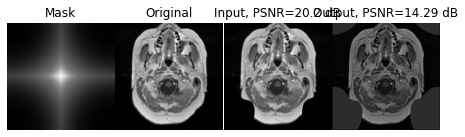

In [3]:
"""
Created on Fri Mar 30 12:39:26 2018
This is the demo code. That should run without making any changes.
Please ensure that demoImage.hdf5 is in the same directory as this file tstDemo.py.

This code will load the learned model from the subdirectory 'savedModels'

This test code will load an  image for  from the demoImage.hdf5 file.

@author: haggarwal
"""
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import numpy as np
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import supportingFunctions as sf

cwd=os.getcwd()
tf.reset_default_graph()

#%% choose a model from savedModels directory

#subDirectory='14Mar_1105pm'
subDirectory="20Sep_0911PM_5L_1K_50E_AG"
subDirectory_test='04Jun_0356pm_5L_10K_50E_AG'
#%%Read the testing data from dataset.hdf5 file

#tstOrg is the original ground truth
#tstAtb: it is the aliased/noisy image
#tstCsm: this is coil sensitivity maps
#tstMask: it is the undersampling mask

tstOrg,tstAtb,tstCsm,tstMask=sf.getTestingData()

#you can also read more testing data from dataset.hdf5 (see readme) file using the command
#tstOrg,tstAtb,tstCsm,tstMask=sf.getData('testing',num=100)

#%% Load existing model. Then do the reconstruction
print ('Now loading the model ...')

modelDir= cwd+'/savedModels/'+subDirectory #complete path
rec=np.empty(tstAtb.shape,dtype=np.complex64) #rec variable will have output

tf.reset_default_graph()
loadChkPoint=tf.train.latest_checkpoint(modelDir)
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
with tf.Session(config=config) as sess:
    new_saver = tf.train.import_meta_graph(modelDir+'/modelTst.meta')
    new_saver.restore(sess, loadChkPoint)
    graph = tf.get_default_graph()
    predT =graph.get_tensor_by_name('predTst:0')
    maskT =graph.get_tensor_by_name('mask:0')
    atbT=graph.get_tensor_by_name('atb:0')
    csmT   =graph.get_tensor_by_name('csm:0')
    wts=sess.run(tf.global_variables())
    dataDict={atbT:tstAtb,maskT:tstMask,csmT:tstCsm }
    rec=sess.run(predT,feed_dict=dataDict)

rec=sf.r2c(rec.squeeze())
print('Reconstruction done')

#%% normalize the data for calculating PSNR

print('Now calculating the PSNR (dB) values')

normOrg=sf.normalize01( np.abs(tstOrg))
normAtb=sf.normalize01( np.abs(sf.r2c(tstAtb)))
normRec=sf.normalize01(np.abs(rec))

psnrAtb=sf.myPSNR(normOrg,normAtb)
psnrRec=sf.myPSNR(normOrg,normRec)

print ('*****************')
print ('  ' + 'Noisy ' + 'Recon')
print ('  {0:.2f} {1:.2f}'.format(psnrAtb,psnrRec))
print ('*****************')

#%% Display the output images
plot= lambda x: plt.imshow(x,cmap=plt.cm.gray) #clim=(0.0, .8)
plt.clf()
plt.subplot(141)

mask_arr = np.fft.fftshift(tstMask[0])
mask_arr = mask_arr.astype("float64")
plot(mask_arr)
plt.axis('off')
plt.title('Mask')
plt.subplot(142)
plot(normOrg)
plt.axis('off')
plt.title('Original')
plt.subplot(143)
plot(normAtb)
plt.title('Input, PSNR='+str(psnrAtb.round(2))+' dB' )
plt.axis('off')
plt.subplot(144)
plot(normRec)
plt.title('Output, PSNR='+ str(psnrRec.round(2)) +' dB')
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0,wspace=.01)
plt.show()
